In [80]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import torch
from utils.Gridworld import Gridworld
from tqdm import tqdm
from utils.miscellaneous import *
from collections import deque
import random
import copy

In [3]:
# Test the game
game = Gridworld(size=4, mode='static')
print(game.display())
game.reward()
action_set = {
0: 'u',
1: 'd',
2: 'l',
3: 'r',
}


[['+' '-' ' ' 'P']
 [' ' 'W' ' ' ' ']
 [' ' ' ' ' ' ' ']
 [' ' ' ' ' ' ' ']]


In [4]:
# Define the Q network 
l1 = len(game.board.render_np().flatten())
l2, l3 = 150, 100
l4 = game.board.size

gamma = 0.9
epsilon = 1.0
learning_rate = 1e-3

model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
epochs = 5000
losses = []
for i in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='player')
    state_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/10.0
    
    state1 = torch.from_numpy(state_).float()
    game_on = 1
    while(game_on):
        qval = model(state1)
        qval_ = qval.data.numpy()
        if np.random.rand() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        # Get new state and reward to the action made
        state2_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/10.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()

        with torch.no_grad():
            newQ = model(state2)
        maxQ = torch.max(newQ)
        if reward == -1:
            Y = reward + (gamma * maxQ)

        else:
            Y = reward

        Y = torch.Tensor([Y,]).detach()
        X = qval[0:1,action_]

        loss = loss_fn(X, Y)
        optimizer.zero_grad()
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        state1 = state2
        if reward != -1:
            game_on = 0
        if epsilon > 0.1:
            epsilon -= (1/epochs)


100%|██████████| 5000/5000 [00:21<00:00, 228.25it/s]


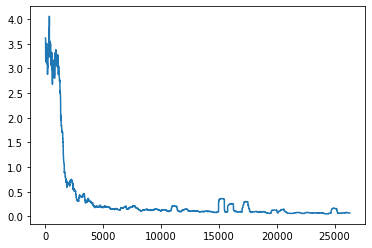

In [5]:
smooth_losses = moving_average(losses, w=500)
plt.plot(smooth_losses)
plt.show()

## Exprerience replay 
This network is not able to learn the 'random' mode of the game. This is mostly due to catastrophic forgetting, in which learning from a single experience may overwrite previously learned action-state associations.

In [81]:
# Define the Q network 
l1 = len(game.board.render_np().flatten())
l2, l3 = 150, 100
l4 = game.board.size

gamma = 0.9
epsilon = 0.9
learning_rate = 1e-3

model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train loop
epochs = 5000
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50 # max number of moves before game over

losses = []
for i in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/100.0
    
    state1 = torch.from_numpy(state1_).float()
    game_on = 1
    mov = 0
    while(game_on):
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if np.random.rand() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        # Get new state and reward to the action made
        state2_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False

        # Create and save the expericne 
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)

            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) 
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]) 
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad():
                Q2 = model(state2_batch)

            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()

            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

        if reward != -1 or mov > max_moves:
            game_on = 0
            mov = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)


losses = np.array(losses)

100%|██████████| 5000/5000 [00:44<00:00, 112.51it/s]


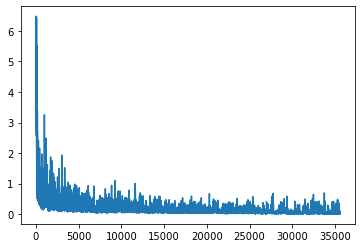

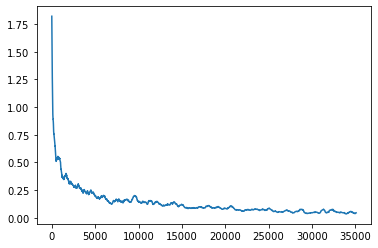

In [85]:
smooth_losses = moving_average(losses, w=500)
plt.plot(losses)
plt.show()
plt.plot(smooth_losses)
plt.show()

## Testing the Deep-Q Network
test the Deep Q network with actual game plays


In [86]:
def test_model(model, mode='static', display = True):
    i = 0
    test_game = Gridworld(mode=mode)
    state_ = test_game.board.render_np().flatten() + np.random.rand(1,64)/10.0
    state = torch.from_numpy(state_).float()
    if display:
        print('Initial state:')
        print(test_game.display())
    game_on = 1
    while(game_on):
        qval = model(state)
        qval_ = qval.data.numpy()
        action_ = np.argmax(qval_)
        action = action_set[action_]
        if display:
            print('Move #: %s; Taking action: %s' % (i, action))

        test_game.makeMove(action)
        state_ = test_game.board.render_np().flatten() + np.random.rand(1,64)/10.0
        state = torch.from_numpy(state_).float()
        if display:
            print(test_game.display())
        reward = test_game.reward()
        if reward != -1:
            if reward > 0:
                game_on = 2
                if display:
                    print("Game won! Reward: %s" % (reward,))
                break
            else:
                game_on = 0 
                if display:
                    print("Game LOST. Reward: %s" % (reward,))
                break
        
        i += 1
        if i > 15:
            if display:
                print("Game LOST. Too many moves")
            break
    win = True if game_on == 2 else False
    return win


In [87]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))


Games played: 1000, # of wins: 940
Win percentage: 0.94


## Target Network
Add target network to improve stabiliy in training process

In [88]:
# Define models

# Define the Q network 
l1 = len(game.board.render_np().flatten())
l2, l3 = 150, 100
l4 = game.board.size

gamma = 0.9
epsilon = 0.9
learning_rate = 1e-3


model = torch.nn.Sequential(
torch.nn.Linear(l1, l2),
torch.nn.ReLU(),
torch.nn.Linear(l2, l3),
torch.nn.ReLU(),
torch.nn.Linear(l3,l4)
)
model2 = model2 = copy.deepcopy(model)
model2.load_state_dict(model.state_dict())


loss_fn = torch.nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


# Training Loop
epochs = 5000
mem_size = 1000
batch_size = 200
replay = deque(maxlen=mem_size)
max_moves = 50 # max number of moves before game over
h = 0
sync_freq = 500
j = 0

losses = []
for i in tqdm(range(epochs)):
    game = Gridworld(size=4, mode='random')
    state1_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/100.0
    
    state1 = torch.from_numpy(state1_).float()
    game_on = 1
    mov = 0
    while(game_on):
        j += 1
        mov += 1
        qval = model(state1)
        qval_ = qval.data.numpy()
        if np.random.rand() < epsilon:
            action_ = np.random.randint(0, 4)
        else:
            action_ = np.argmax(qval_)
        
        action = action_set[action_]
        game.makeMove(action)
        # Get new state and reward to the action made
        state2_ = game.board.render_np().flatten() \
             + np.random.rand(1,64)/100.0
        state2 = torch.from_numpy(state2_).float()
        reward = game.reward()
        done = True if reward > 0 else False

        # Create and save the expericne 
        exp = (state1, action_, reward, state2, done)
        replay.append(exp)
        state1 = state2

        if len(replay) > batch_size:
            minibatch = random.sample(replay, batch_size)

            state1_batch = torch.cat([s1 for (s1,a,r,s2,d) in minibatch]) 
            action_batch = torch.Tensor([a for (s1,a,r,s2,d) in minibatch]) 
            reward_batch = torch.Tensor([r for (s1,a,r,s2,d) in minibatch])
            state2_batch = torch.cat([s2 for (s1,a,r,s2,d) in minibatch]) 
            done_batch = torch.Tensor([d for (s1,a,r,s2,d) in minibatch])

            Q1 = model(state1_batch)
            with torch.no_grad(): #### Use the Target network for prediction!!
                Q2 = model2(state2_batch)

            Y = reward_batch + gamma * ((1 - done_batch) * torch.max(Q2,dim=1)[0])
            X = Q1.gather(dim=1,index=action_batch.long().unsqueeze(dim=1)).squeeze()

            loss = loss_fn(X, Y.detach())
            optimizer.zero_grad()
            loss.backward()
            losses.append(loss.item())
            optimizer.step()

            if j % sync_freq == 0:    # Update the target nework every sync_freq epoch
                model2.load_state_dict(model.state_dict())

        if reward != -1 or mov > max_moves:
            game_on = 0
            mov = 0

    if epsilon > 0.1:
        epsilon -= (1/epochs)


losses = np.array(losses)

100%|██████████| 5000/5000 [00:47<00:00, 104.96it/s]


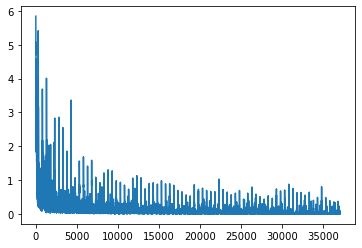

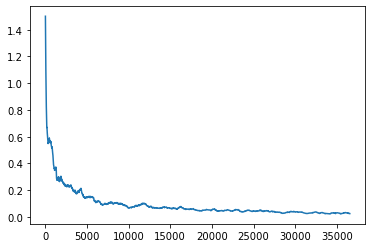

In [89]:
smooth_losses = moving_average(losses, w=500)
plt.plot(losses)
plt.show()
plt.plot(smooth_losses)
plt.show()

In [94]:
max_games = 1000
wins = 0
for i in range(max_games):
    win = test_model(model, mode='random', display=False)
    if win:
        wins += 1
win_perc = float(wins) / float(max_games)
print("Games played: {0}, # of wins: {1}".format(max_games,wins))
print("Win percentage: {}".format(win_perc))


Games played: 1000, # of wins: 934
Win percentage: 0.934
